# Tumoroscope in PyMC

## Setup

In [1]:
from dataclasses import dataclass

import arviz as az
import janitor  # noqa: F401
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy.stats
import seaborn as sns

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

## Introduction

![tumoroscope overview](tumoroscope-overview.png)

## Model

In [225]:
@dataclass
class TumoroscopeData:
    """Tumoroscope model data."""

    K: int  # number of clones
    S: int  # number of spots
    P: int  # number of mutation positions
    F: np.ndarray  # Prevelance of clones from bulk-DNA seq.
    Lambda: np.ndarray  # Number of cell counted per spot
    C: np.ndarray  # Zygosity per position and clone
    D_obs: np.ndarray | None  # Read count per position per spot
    A_obs: np.ndarray | None  # Alternated reads per position per spot
    zeta_s: float = 1  # Pi hyper-parameter
    F_0: float = 0.01  # "pseudo-frequency" for lower bound on clone proportion
    l: float = 100  # Scaling factor to discretize F
    r: float = 0.09  # shape parameter for Gamma over Phi
    p: float = 1  # rate parameter for Gamma over Phi


def _prefixed_index(n: int, prefix: str) -> list[str]:
    return [f"{prefix}{i}" for i in np.arange(n)]


def _check_tumoroscope_data(data: TumoroscopeData) -> None:
    assert data.F.sum() == 1.0
    assert data.F.ndim == 1
    assert data.F.shape[0] == data.K


def _make_tumoroscope_model_coords(data: TumoroscopeData) -> dict[str, list[str]]:
    coords = {
        "clone": _prefixed_index(data.K, "c"),
        "spot": _prefixed_index(data.S, "s"),
        "position": _prefixed_index(data.P, "p"),
    }
    return coords


def tumoroscope(data: TumoroscopeData) -> pm.Model:
    _check_tumoroscope_data(data)
    coords = _make_tumoroscope_model_coords(data)
    with pm.Model(coords=coords) as model:
        ζ_s = pm.ConstantData("ζ_s", data.zeta_s)
        ℓ = pm.ConstantData("ℓ", data.l)
        F_0 = pm.ConstantData("F0", data.F_0)
        F = pm.ConstantData("F", data.F)
        Λ = pm.ConstantData("Λ", data.Lambda, dims="spot")
        r = pm.ConstantData("r", data.r)
        p = pm.ConstantData("p", data.p)
        C = pm.ConstantData("C", data.C, dims=("position", "clone"))

        F_prime = pm.Deterministic("F_prime", ℓ * 20 * F / 20)

        Π = pm.Beta("Π", alpha=ζ_s / data.K, beta=1, dims=("spot", "clone"))
        Z = pm.Bernoulli("Z", p=Π, dims=("spot", "clone"))
        G = pm.Gamma("G", F_prime**Z * F_0 ** (1 - Z), 1, dims=("spot", "clone"))
        H = pm.Deterministic("H", G / G.sum(axis=1)[:, None], dims=("spot", "clone"))

        N = pm.Poisson("N", Λ, dims="spot")
        Φ = pm.Gamma("Φ", r, p, dims=("position", "clone"))
        D = pm.Poisson(
            "D", N * H.dot(Φ.T).T, dims=("position", "spot"), observed=data.D_obs
        )

        _A_num = H[:, 1:].dot((Φ[:, 1:] * C[:, 1:]).T).T
        _A_denom = H[:, 1:].dot(Φ[:, 1:].T).T
        A = pm.Binomial(
            "A", D, _A_num / _A_denom, dims=("position", "spot"), observed=data.A_obs
        )
    return model

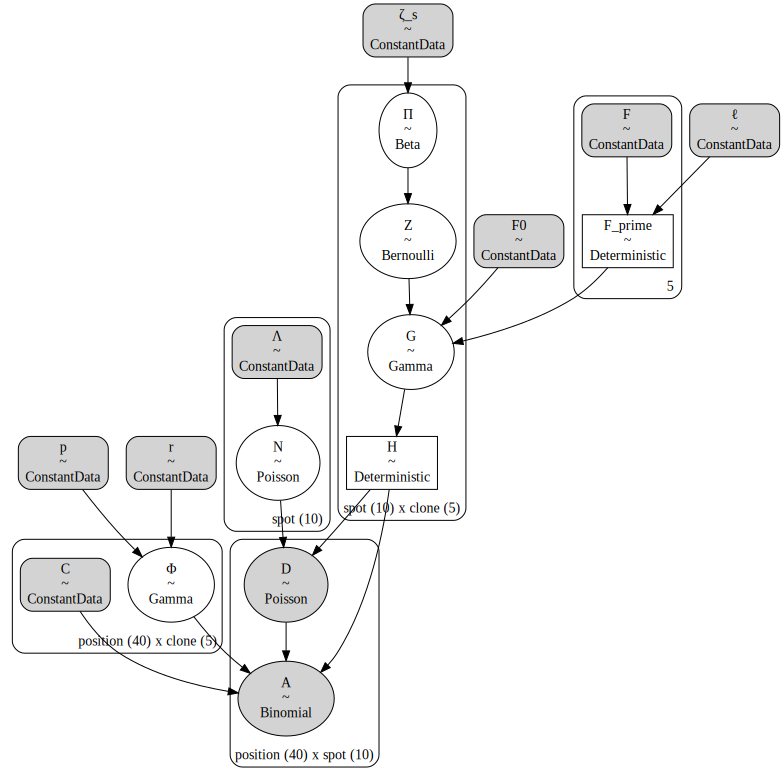

In [226]:
np.random.seed(234)
mock_tumor_data = TumoroscopeData(
    K=5,
    S=10,
    P=40,
    F=np.ones(5) / 5.0,
    Lambda=np.random.randint(1, 20, size=10),
    C=np.random.beta(2, 2, size=(40, 5)),
    D_obs=np.random.randint(2, 20, size=(40, 10)),
    A_obs=np.random.randint(2, 20, size=(40, 10)),
)

m = tumoroscope(mock_tumor_data)
pm.model_to_graphviz(m)

TODO:

- generate mock data and test model
- explore prior distributions over the current user-supplied hyper-parameters
- try to use Dirichlet for $P(H|F^\prime,F_0,Z)$ like the Methods explains

## Prior predictive sampling

In [228]:
example_input_data = TumoroscopeData(
    K=5,
    S=10,
    P=40,
    F=np.array([0.01, 0.05, 0.15, 0.3, 0.49]),
    Lambda=np.ones(10) * 5,
    C=np.ones((40, 5), float),
    D_obs=None,
    A_obs=None,
)

with tumoroscope(example_input_data) as m:
    prior_pred = pm.sample_prior_predictive(
        500, var_names=["D", "A", "H", "G", "Z", "Π", "Φ", "N"], random_seed=123
    )

Sampling: [A, D, G, N, Z, Π, Φ]
INFO:pymc:Sampling: [A, D, G, N, Z, Π, Φ]


In [229]:
prior_pred.constant_data["Λ"].values

array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5.])

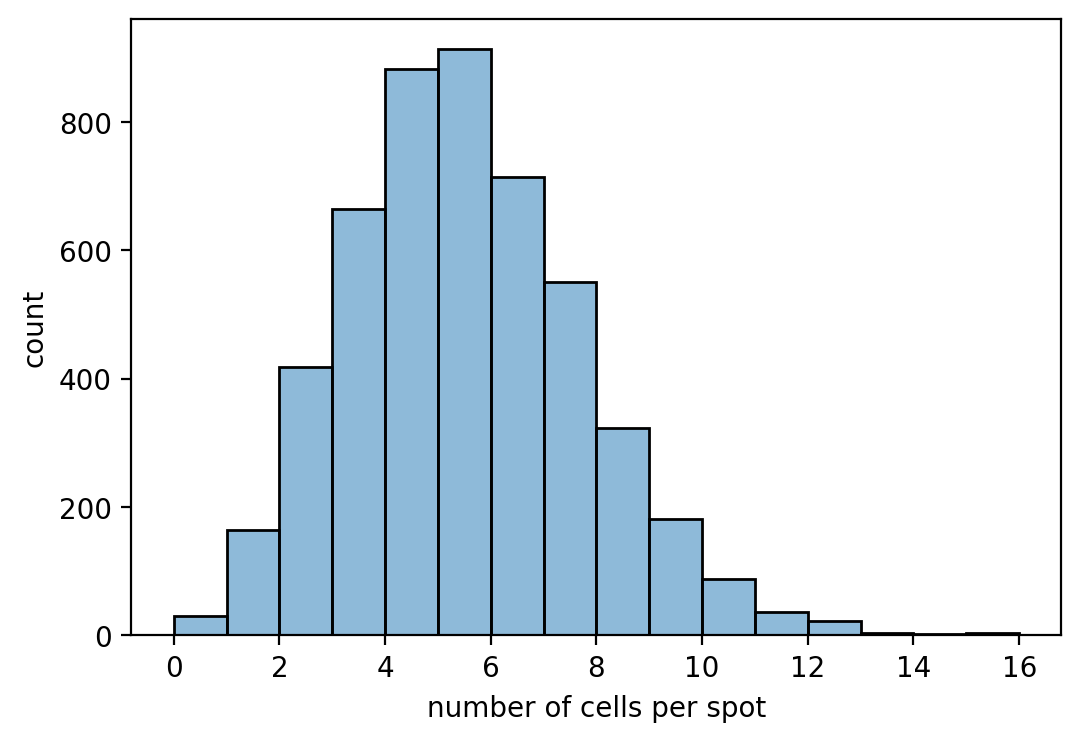

In [235]:
_, ax = plt.subplots(figsize=(6, 4))
sns.histplot(prior_pred.prior["N"].values.flatten(), alpha=0.5, binwidth=1, ax=ax)
ax.set_xlabel("number of cells per spot")
ax.set_ylabel("count")
plt.show()

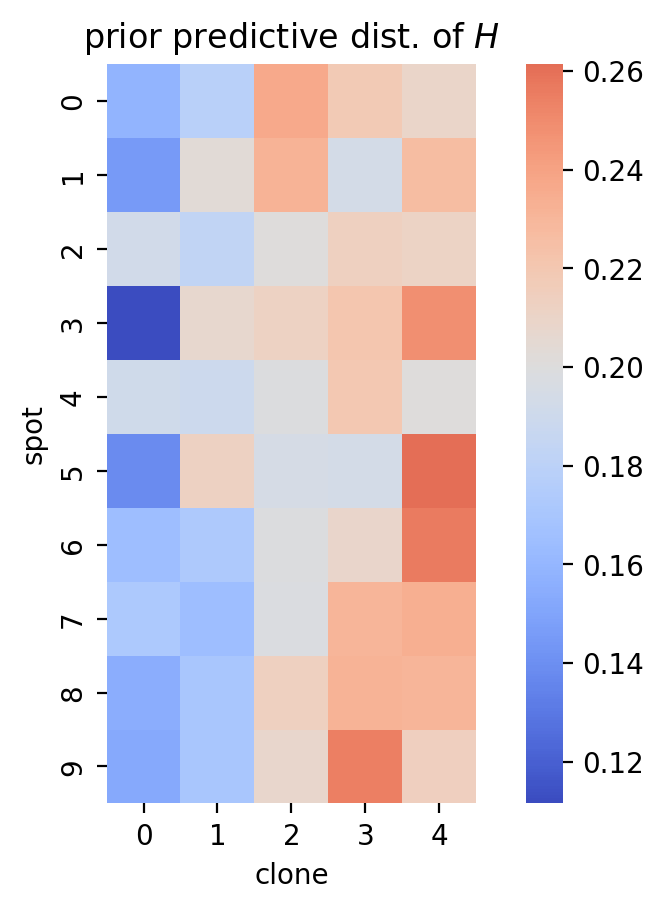

In [237]:
H_mean = prior_pred.prior["H"].values.squeeze().mean(axis=0)
ax = sns.heatmap(
    data=H_mean, cmap="coolwarm", center=1 / mock_tumor_data.K, square=True
)
ax.set_xlabel("clone")
ax.set_ylabel("spot")
ax.set_title("prior predictive dist. of $H$")
plt.show()

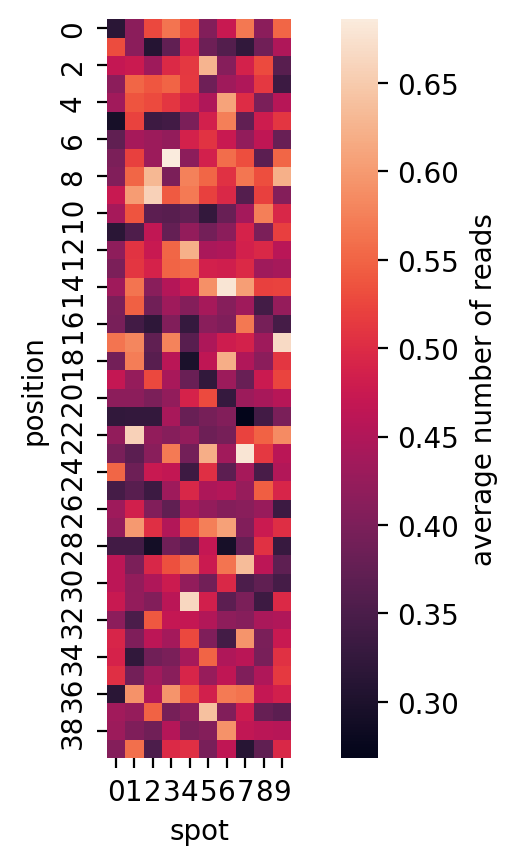

In [246]:
D_prior_mean = prior_pred.prior["D"].mean(axis=(0, 1)).values
ax = sns.heatmap(
    D_prior_mean, square=True, cbar_kws={"label": "average number of reads"}
)
ax.set_xlabel("spot")
ax.set_ylabel("position")
plt.show()

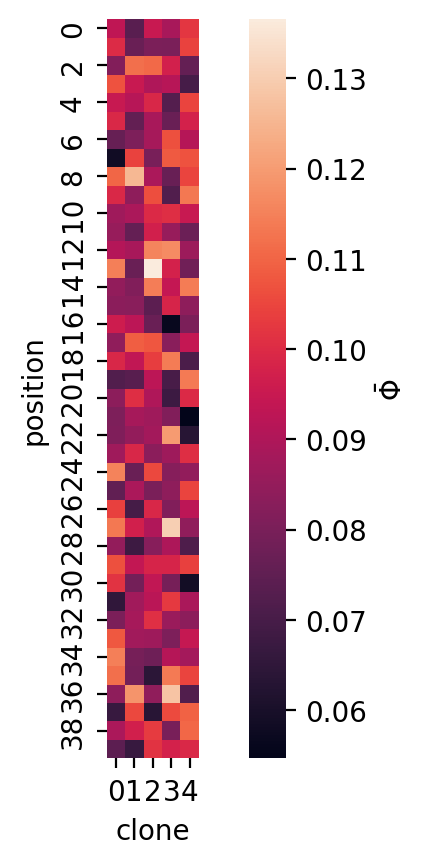

In [261]:
phi_prior_mean = prior_pred.prior["Φ"].mean(axis=(0, 1)).values
ax = sns.heatmap(phi_prior_mean, square=True, cbar_kws={"label": r"$\bar{\Phi}$"})
ax.set_xlabel("clone")
ax.set_ylabel("position")
plt.show()

## Simulation experiments

In [159]:
np.random.seed(8383)

num_clones, num_spots, num_positions = 5, 20, 100

cell_counts = np.random.randint(2, 8, size=num_spots).astype(float)

clone_mutations = np.hstack(
    [np.random.binomial(1, p, size=(100, 1)) for p in [0.05, 0.1, 0.2, 0.3, 0.4]]
).astype(float)

clone_props_params = [(2, 2), (1, 3), (4, 2), (5, 5), (1, 1)]
spots_x = np.linspace(0, 1, num_spots)
clone_proportions = np.hstack(
    [scipy.stats.beta(a, b).pdf(spots_x)[:, None] for a, b in clone_props_params]
)
clone_proportions += 0.01
clone_proportions = clone_proportions / clone_proportions.sum(axis=1)[:, None]
F = np.array([a / (a + b) for a, b in clone_props_params])
F = F / F.sum()

read_coverage = np.random.poisson(100, size=(num_positions, num_spots)).astype(float)
zygosity = np.random.beta(5, 2, size=(num_positions, num_clones))
alt_read_counts = (clone_mutations * zygosity).dot(clone_proportions.T) * read_coverage

Actual clone proportions vs. the randomly sampled clone proportions averaging across spots:

In [160]:
F, clone_proportions.mean(axis=0)

(array([0.20689655, 0.10344828, 0.27586207, 0.20689655, 0.20689655]),
 array([0.17932913, 0.21931641, 0.1922926 , 0.15698317, 0.25207869]))

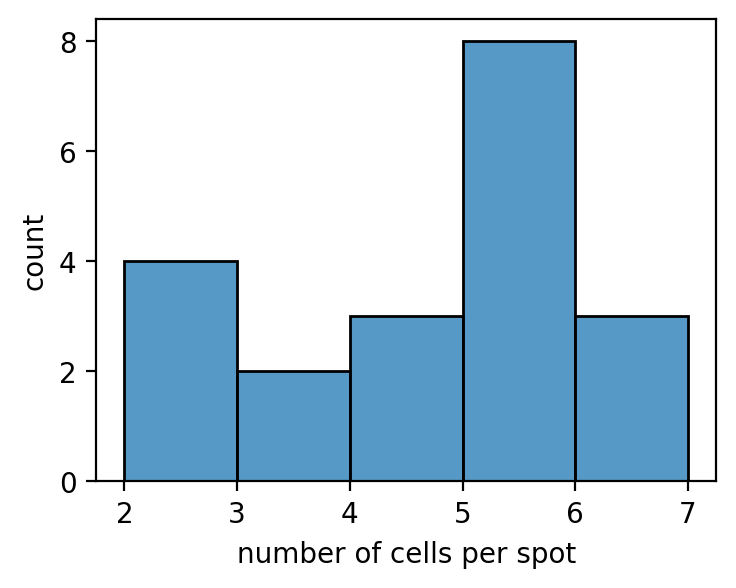

In [161]:
_, ax = plt.subplots(figsize=(4, 3))
sns.histplot(cell_counts.flatten(), binwidth=1, ax=ax)
ax.set_xlabel("number of cells per spot")
ax.set_ylabel("count")
plt.show()

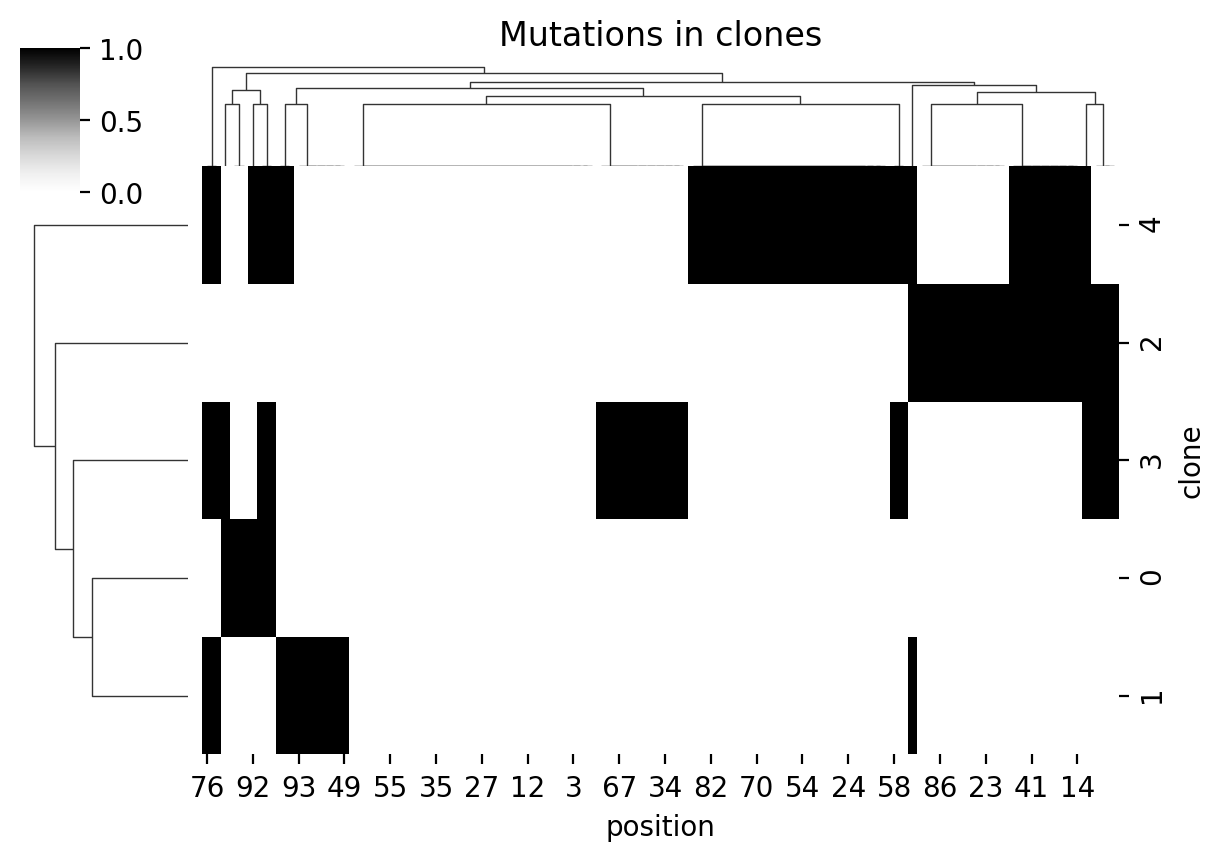

In [162]:
cg = sns.clustermap(
    clone_mutations.T, figsize=(6, 4), dendrogram_ratio=(0.15, 0.15), cmap="Greys"
)
cg.ax_heatmap.set_xlabel("position")
cg.ax_heatmap.set_ylabel("clone")
cg.ax_col_dendrogram.set_title("Mutations in clones")
plt.show()

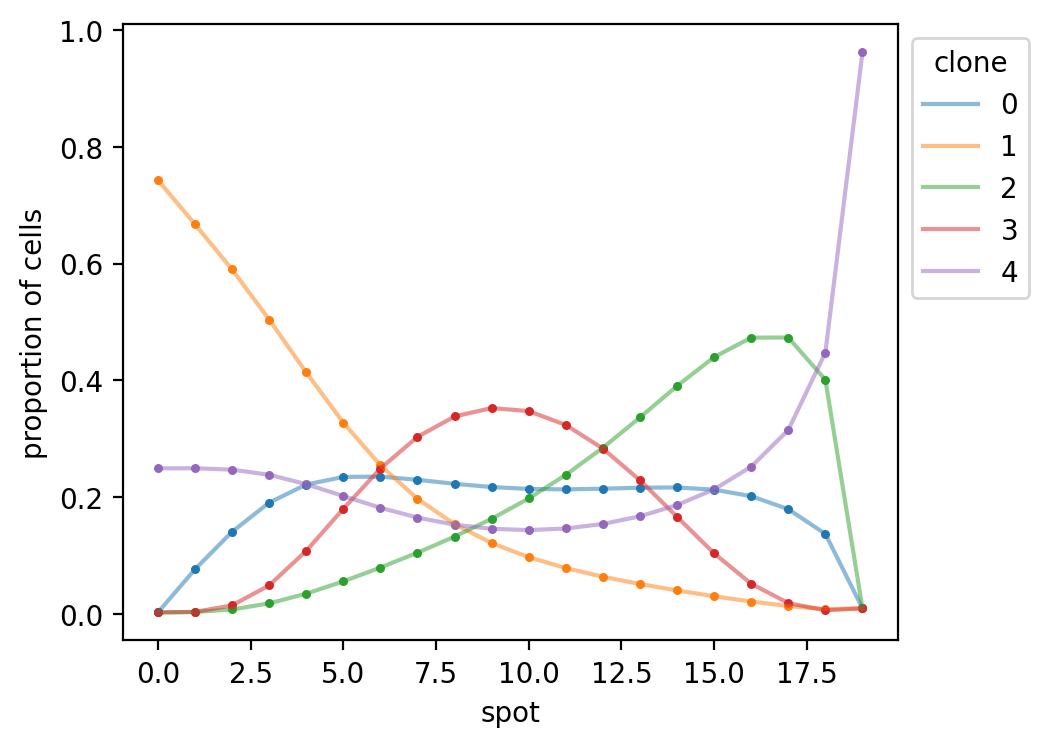

In [163]:
_, ax = plt.subplots(figsize=(5, 4))

for i in range(clone_proportions.shape[1]):
    x = np.arange(clone_proportions.shape[0])
    ax.plot(x, clone_proportions[:, i], label=f"{i}", alpha=0.5)
    ax.scatter(x, clone_proportions[:, i], s=5)

ax.set_xlabel("spot")
ax.set_ylabel("proportion of cells")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1), title="clone")
plt.show()

Text(50.722222222222214, 0.5, 'clone')

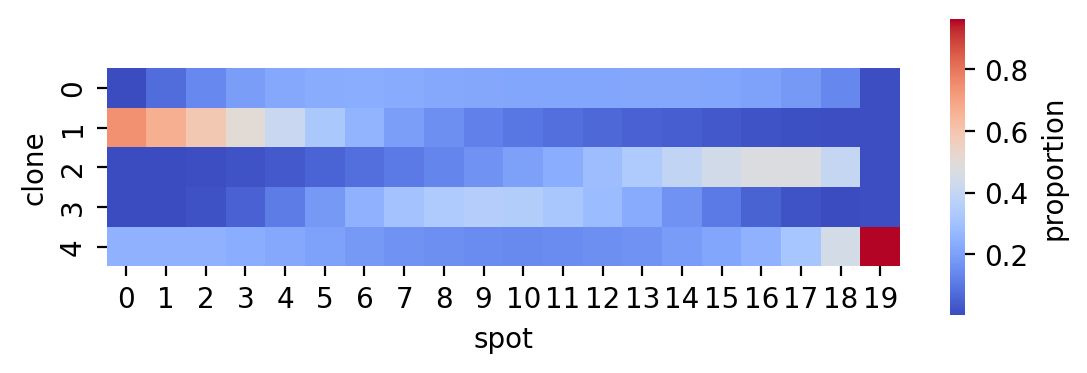

In [164]:
ax = sns.heatmap(
    clone_proportions.T,
    cmap="coolwarm",
    square=True,
    cbar_kws={"shrink": 0.4, "label": "proportion"},
)
ax.set_xlabel("spot")
ax.set_ylabel("clone")

<function matplotlib.pyplot.show(close=None, block=None)>

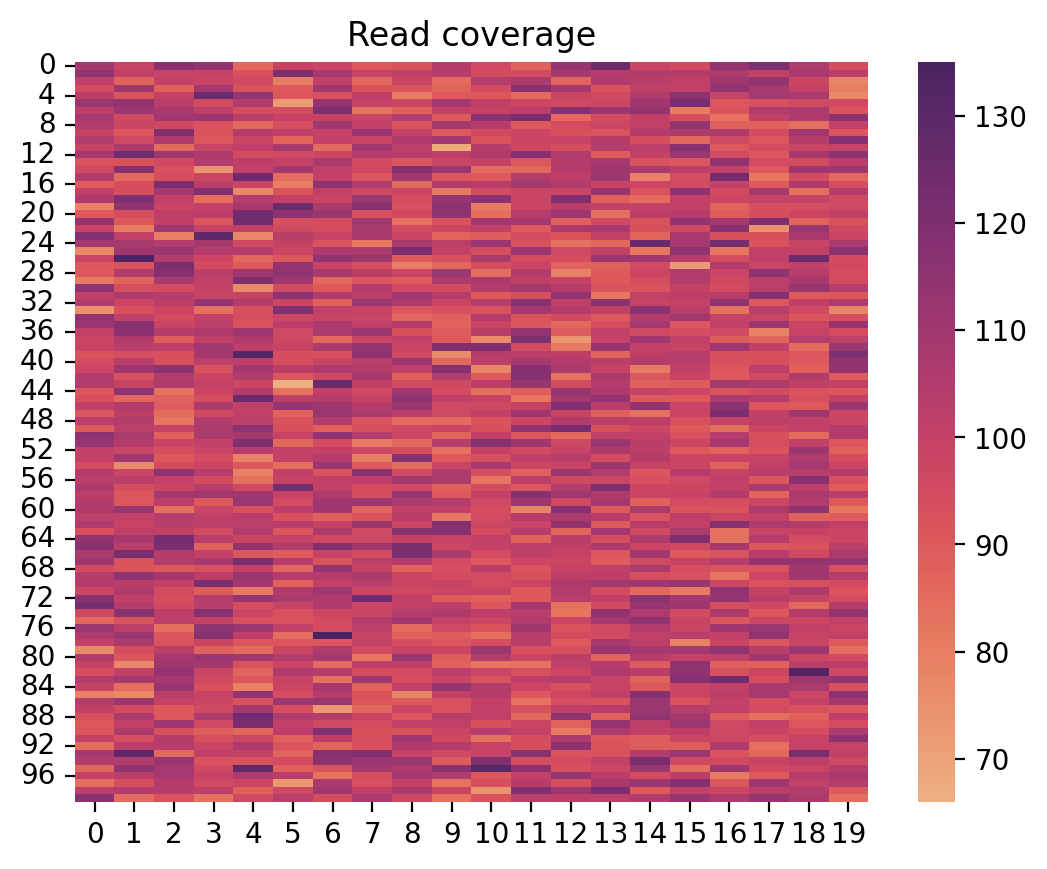

In [165]:
ax = sns.heatmap(read_coverage, cmap="flare")
ax.set_title("Read coverage")
plt.show

In [ ]:
sim_data = TumoroscopeData(
    K=num_clones,
    S=num_spots,
    P=num_positions,
    F=F,
    Lambda=cell_counts,
    C=zygosity,
    D_obs=read_coverage,
    A_obs=alt_read_counts,
    zeta_s=num_clones,
)

with tumoroscope(mock_tumor_data):
    sim_trace = pm.sample(draws=500, tune=500, chains=2, cores=2, random_seed=10)

---

## Session information

In [8]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-10-05

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

Compiler    : Clang 13.0.1 
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: JHCookMac.local

Git branch: tumoroscope

numpy     : 1.23.3
seaborn   : 0.12.0
arviz     : 0.12.1
matplotlib: 3.6.0
pandas    : 1.5.0
pymc      : 4.2.1
janitor   : 0.22.0

